# Systolic Array Design


In [1]:
import pyrtl
from hardware_accelerators import *

from IPython.display import *
import numpy as np

# Weight Stationary Dataflow

like TPU architecture


## Simple Processing Element


We will use a weight stationary dataflow in our systolic array. Since weights need to be updated less frequently than the inputs or activations flowing through them, this will reduce the amount of memory IO and therefore the power requirements.

To start, lets focus on building the most simple version of the processing element. Each element in the array will have the following inputs and outputs:

- activation value
- weight value
- partial sum

Activations will flow from left to right, weights will flow from top to bottom, and both are passed through unchanged.  
The accumulated value output will be the result of adding the accumulation input with the product of the current activation and weight.


In [310]:
from pyrtl import *
from hardware_accelerators.dtypes.base import BaseFloat
from dataclasses import dataclass
from typing import Type, Self


@dataclass
class PEOutputs:
    """Container for PE outputs to make connections clear"""

    data: Register  # Passes to PE to the right
    weight: Register  # Passes to PE below
    accum: Register  # Passes to PE below


class ProcessingElement:
    def __init__(
        self,
        data_type: Type[BaseFloat],
        accum_type: Type[BaseFloat],
        multiplier_type,
        adder_type,
        pipeline_mult: bool = False,
    ):
        """Initialize processing element hardware

        Args:
            data_type: Float type for data/weight (Float8, BF16 etc)
            accum_type: Float type for accumulation
            multiplier_type: Floating point multiplier implementation
            adder_type: Floating point adder implementation
            pipeline_mult: If True, register multiplication output before passing to accumulator

        TODO: Add control logic for:
        - Activation flow control
        - Accumulator reset/clear
        """
        # Get bit widths from format specs
        data_width = data_type.FORMAT_SPEC.total_bits
        accum_width = accum_type.FORMAT_SPEC.total_bits

        # Input/output registers
        self.data_reg = Register(bitwidth=data_width)
        self.weight_reg = Register(bitwidth=data_width)
        self.accum_in = WireVector(bitwidth=accum_width)
        self.accum_reg = Register(bitwidth=accum_width)

        # Control signals
        self.weight_we = WireVector(1)  # Weight write enable
        self.pe_en = WireVector(1)  # Enable writing to the data input register
        self.mul_en = WireVector(1)  # Enable writing to product register
        self.adder_en = WireVector(1)  # Enable writing to the accumulator register

        # Multiply-accumulate logic
        product = multiplier_type(
            self.data_reg,
            self.weight_reg,
            data_type.FORMAT_SPEC.exponent_bits,
            data_type.FORMAT_SPEC.mantissa_bits,
        )

        # TODO: Add float type conversion logic to pass different bitwidths to the accumulator
        self.pipeline_mult = pipeline_mult

        if pipeline_mult:
            product_reg = Register(bitwidth=accum_width)
            product_reg.next <<= product
            sum_result = adder_type(
                product_reg,
                self.accum_in,
                accum_type.FORMAT_SPEC.exponent_bits,
                accum_type.FORMAT_SPEC.mantissa_bits,
            )
        else:
            sum_result = adder_type(
                product,
                self.accum_in,
                accum_type.FORMAT_SPEC.exponent_bits,
                accum_type.FORMAT_SPEC.mantissa_bits,
            )

        self.accum_reg.next <<= sum_result

        # Store registers in output container
        self.outputs = PEOutputs(
            data=self.data_reg, weight=self.weight_reg, accum=self.accum_reg
        )

    def connect_data(self, source: Self | WireVector):
        """Connect data input from source (PE or external input)"""
        if isinstance(source, ProcessingElement):
            data_in = source.outputs.data
        else:
            data_in = source

        with conditional_assignment:
            with self.pe_en:
                self.data_reg.next |= data_in

    def connect_weight(self, source: Self | WireVector):
        """Connect weight input from source (PE or external input)"""
        if isinstance(source, ProcessingElement):
            weight_in = source.outputs.weight
        else:
            weight_in = source

        # Conditional weight update based on enable signal
        with conditional_assignment:
            with self.weight_we:
                self.weight_reg.next |= weight_in

    def connect_accum(self, source: Self | WireVector):
        """Connect accumulator input from source (PE or external input)"""
        if isinstance(source, ProcessingElement):
            self.accum_in <<= source.outputs.accum
        else:
            self.accum_in <<= source

    def connect_weight_enable(self, enable: WireVector):
        """Connect weight write enable signal"""
        self.weight_we <<= enable

    def connect_pe_enable(self, enable: WireVector):
        """Connect PE enable signal. Controls writing to the data input register"""
        self.pe_en <<= enable

    def connect_mul_enable(self, enable: WireVector):
        """Connect multiplier enable signal. Controls writing to the product register"""
        if self.pipeline_mult:
            self.mul_en <<= enable
            product_reg = Register(bitwidth=self.accum_width)
            product_reg.next <<= product
            sum_result = adder_type(
                product_reg,
                self.accum_in,
                accum_type.FORMAT_SPEC.exponent_bits,
                accum_type.FORMAT_SPEC.mantissa_bits,
            )

    def connect_adder_enable(self, enable: WireVector):
        """Connect adder enable signal. Controls writing to the accumulator register"""
        self.adder_en <<= enable

    def connect_control_signals(
        self,
        w_en: WireVector,
        pe_en: WireVector,
        mul_en: WireVector,
        adder_en: WireVector,
    ):
        """Connect control signals to the processing element

        Args:
            w_en (WireVector): Weight write enable signal. Controls writing to the weight register
            pe_en (WireVector): PE enable signal. Controls writing to the data input register
            mul_en (WireVector): Multiplier enable signal. Controls writing to the product register
            add_en (WireVector): Adder enable signal. Controls writing to the accumulator register
        """
        self.weight_we <<= w_en
        self.pe_en <<= pe_en
        self.mul_en <<= mul_en
        self.adder_en <<= adder_en

## Systolic Array Class


In [263]:
from typing import List, Type
from pyrtl import *
from dataclasses import dataclass


@dataclass
class SystolicArrayPorts:
    """Container for array I/O ports"""

    # Input ports for each row/column
    data_in: List[WireVector]  # Input activations flowing left->right
    weights_in: List[WireVector]  # Input weights flowing top->bottom
    weight_load: WireVector  # Weight load enable signal (1-bit)
    # Output ports from bottom row
    results_out: List[WireVector]  # Output partial sums


class SystolicArray:
    def __init__(
        self,
        size: int,
        data_type: Type[BaseFloat],
        accum_type: Type[BaseFloat],
        multiplier_type,
        adder_type,
        pipeline_mult: bool = False,
    ):
        """Initialize systolic array hardware structure

        Args:
            size: N for NxN array
            data_type: Number format for inputs (Float8, BF16)
            accum_type: Number format for accumulation
            multiplier_type: Multiplier implementation to use
            adder_type: Adder implementation to use
            pipeline_mult: Add pipeline register after multiplication
        """
        self.size = size
        self.data_type = data_type
        self.accum_type = accum_type

        # Create interface wires
        data_width = data_type.FORMAT_SPEC.total_bits
        accum_width = accum_type.FORMAT_SPEC.total_bits

        self.data_in = [WireVector(bitwidth=data_width) for _ in range(size)]
        self.weights_in = [WireVector(bitwidth=data_width) for _ in range(size)]
        self.weight_load = WireVector(bitwidth=1)
        self.results_out = [WireVector(bitwidth=accum_width) for _ in range(size)]

        # Create PE array
        self.pe_array = [
            [
                ProcessingElement(
                    data_type, accum_type, multiplier_type, adder_type, pipeline_mult
                )
                for _ in range(size)
            ]
            for _ in range(size)
        ]

        # Connect PEs in systolic pattern
        self._connect_array()

        # Package ports for external access
        self.ports = SystolicArrayPorts(
            data_in=self.data_in,
            weights_in=self.weights_in,
            weight_load=self.weight_load,
            results_out=self.results_out,
        )

    def _connect_array(self):
        """Connect processing elements in systolic pattern

        Data flow patterns:
        - Activations flow left to right
        - Weights flow top to bottom
        - Partial sums flow top to bottom
        """
        for row in range(self.size):
            for col in range(self.size):
                pe = self.pe_array[row][col]

                # Connect activation input:
                # First column gets external input, others connect to PE on left
                if col == 0:
                    pe.connect_data(self.data_in[row])
                else:
                    pe.connect_data(self.pe_array[row][col - 1])

                # Connect weight input:
                # First row gets external input, others connect to PE above
                if row == 0:
                    pe.connect_weight(self.weights_in[col])
                else:
                    pe.connect_weight(self.pe_array[row - 1][col])

                # Connect accumulator input:
                # First row starts at 0, others connect to PE above
                if row == 0:
                    pe.connect_accum(Const(0))
                else:
                    pe.connect_accum(self.pe_array[row - 1][col])

                # Connect weight enable to all PEs
                pe.connect_weight_enable(self.weight_load)

                # Connect bottom row results to output ports
                if row == self.size - 1:
                    self.results_out[col] <<= pe.outputs.accum

    def connect_data_input(self, row: int, source: WireVector):
        """Connect data input for specified row"""
        assert 0 <= row < self.size
        self.data_in[row] <<= source

    def connect_weight_input(self, col: int, source: WireVector):
        """Connect weight input for specified column"""
        assert 0 <= col < self.size
        self.weights_in[col] <<= source

    def connect_weight_load(self, source: WireVector):
        """Connect weight load enable signal"""
        self.weight_load <<= source

    def connect_result_output(self, col: int, dest: WireVector):
        """Connect result output from specified column"""
        assert 0 <= col < self.size
        dest <<= self.results_out[col]

## Systolic Data Setup


In [257]:
class SystolicSetup:
    """Creates diagonal delay pattern for systolic array I/O

    For a 3x3 array, creates following pattern of registers:
    (R = register, -> = connection)

    Row 0:  [R] ------->
    Row 1:  [R]->[R] -->
    Row 2:  [R]->[R]->[R]

    - Each row i contains i+1 registers
    - Input connects to leftmost register
    - Output reads from rightmost register
    - Can be used for both input and output buffering
    """

    def __init__(self, size: int, data_width: int):
        """Initialize delay register network

        Args:
            size: Number of rows in network
            data_width: Bit width of data values
        """
        self.size = size
        self.data_width = data_width

        # Create input wires for each row
        self.inputs = [WireVector(bitwidth=data_width) for _ in range(size)]

        # Create delay register network - more delays for lower rows
        self.delay_regs = []
        self.outputs = [WireVector(bitwidth=data_width) for _ in range(size)]

        for i in range(size):  # Create num rows equal to the size of systolic array
            row: List[Register] = []
            # Number of buffer registers equals row index for lower triangular config
            for j in range(i + 1):
                row.append(Register(bitwidth=data_width))
                if j != 0:
                    # Left most register connects to inputs, others connect to previous reg
                    row[j].next <<= row[j - 1]

            # Connect row input and output
            row[0].next <<= self.inputs[i]
            self.outputs[i] <<= row[-1]
            self.delay_regs.append(row)

    def connect_input(self, row: int, source: WireVector):
        """Connect input for specified row"""
        assert 0 <= row < self.size
        self.inputs[row] <<= source

    def connect_output(self, row, dest: WireVector):
        """Connect final register in a buffer row to an output destination"""
        dest <<= self.outputs[row]

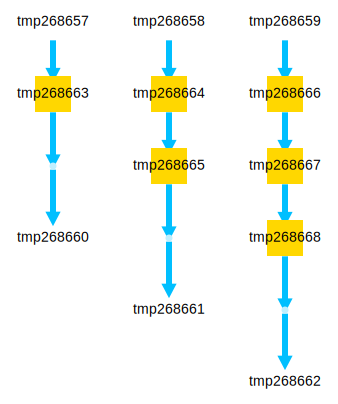

In [258]:
reset_working_block()

setup = SystolicSetup(size=3, data_width=8)

SVG(block_to_svg(split_state=False))

## Matrix Multiply Unit Top Level


In [269]:
class MatrixMultiplier:
    """Top level systolic array matrix multiplier hardware"""

    def __init__(
        self,
        size: int,
        data_type: Type[BaseFloat],
        accum_type: Type[BaseFloat],
        multiplier_type,
        adder_type,
        pipeline_mult: bool = False,
    ):
        self.size = size
        self.data_type = data_type
        self.accum_type = accum_type
        self.data_width = data_type.FORMAT_SPEC.total_bits
        self.accum_width = accum_type.FORMAT_SPEC.total_bits

        # Create hardware components
        self.systolic_array = SystolicArray(
            size, data_type, accum_type, multiplier_type, adder_type, pipeline_mult
        )
        self.systolic_setup = SystolicSetup(size, self.data_width)
        self.result_buffer = SystolicSetup(size, self.accum_width)

        # Connect internal components
        self._connect_internal_components()

    def _connect_internal_components(self):
        """Connect systolic array to input/output buffers"""
        for i in range(self.size):
            self.systolic_array.connect_data_input(i, self.systolic_setup.outputs[i])
            self.systolic_array.connect_result_output(
                i, self.result_buffer.inputs[-i - 1]
            )

    def _validate_wire_list(
        self, wires: List[WireVector], expected_width: int, purpose: str
    ):
        """Validate a list of wires meets requirements"""
        if len(wires) != self.size:
            raise ValueError(f"{purpose} requires {self.size} wires, got {len(wires)}")
        if not all(isinstance(w, WireVector) for w in wires):
            raise TypeError(f"All {purpose} must be WireVector instances")
        if not all(w.bitwidth == expected_width for w in wires):
            raise ValueError(f"All {purpose} must have bitwidth {expected_width}")

    def _split_wide_wire(
        self, wire: WireVector, width_per_slice: int
    ) -> List[WireVector]:
        """Split a wide wire into equal slices"""
        expected_width = width_per_slice * self.size
        if wire.bitwidth != expected_width:
            raise ValueError(
                f"Wide wire must have bitwidth {expected_width}, got {wire.bitwidth}"
            )
        # Use chop instead of manual slicing
        return chop(wire, *([width_per_slice] * self.size))

    def connect_weight_enable(self, enable: WireVector):
        """Connect weight enable signal"""
        if not isinstance(enable, WireVector) or enable.bitwidth != 1:
            raise ValueError("Weight enable must be 1-bit WireVector")
        self.systolic_array.connect_weight_load(enable)

    def connect_weights(self, weights: WireVector | List[WireVector]):
        """Connect weight inputs either as list of wires or single wide wire"""
        if isinstance(weights, list):
            self._validate_wire_list(weights, self.data_width, "weight inputs")
            weight_wires = weights
        else:
            # Split wide wire into individual weight wires
            weight_wires = chop(weights, *([self.data_width] * self.size))

        for i, wire in enumerate(weight_wires):
            self.systolic_array.connect_weight_input(i, wire)

    def connect_data(self, data: WireVector | List[WireVector]):
        """Connect data inputs either as list of wires or single wide wire"""
        if isinstance(data, list):
            self._validate_wire_list(data, self.data_width, "data inputs")
            data_wires = data
        else:
            # Split wide wire into individual data wires
            data_wires = chop(data, *([self.data_width] * self.size))

        for i, wire in enumerate(data_wires):
            self.systolic_setup.connect_input(i, wire)

    def connect_results(self, results: WireVector | List[WireVector]):
        """Connect result outputs either as list of wires or single wide wire"""
        if isinstance(results, list):
            self._validate_wire_list(results, self.accum_width, "result outputs")
            result_wires = results
        else:
            # Split wide wire into individual result wires
            result_wires = chop(results, *([self.accum_width] * self.size))

        for i, wire in enumerate(result_wires):
            self.result_buffer.connect_output(-i - 1, wire)

## Simulation Class


In [301]:
class MatrixMultiplierSimulator:
    def __init__(self, matrix_multiplier: MatrixMultiplier):
        self.mmu = matrix_multiplier
        self.size = matrix_multiplier.size
        self.data_type = matrix_multiplier.data_type
        self.accum_type = matrix_multiplier.accum_type

        # Create I/O ports
        self.weight_enable = Input(1, "weight_enable")
        self.weight_ports = [
            Input(self.mmu.data_width, f"weight_{i}") for i in range(self.size)
        ]
        self.data_ports = [
            Input(self.mmu.data_width, f"data_{i}") for i in range(self.size)
        ]
        self.result_ports = [
            Output(self.mmu.accum_width, f"result_{i}") for i in range(self.size)
        ]

        # Connect ports to matrix multiplier
        self.mmu.connect_weight_enable(self.weight_enable)
        self.mmu.connect_weights(self.weight_ports)
        self.mmu.connect_data(self.data_ports)
        self.mmu.connect_results(self.result_ports)

        # Initialize simulation
        self.sim = Simulation()
        self.sim_inputs = {
            "weight_enable": 0,
            **{f"weight_{i}": 0 for i in range(self.size)},
            **{f"data_{i}": 0 for i in range(self.size)},
        }

        # Initialize matrices as None
        self.matrix_a = None
        self.matrix_b = None
        self._iter_state = None
        self.result_matrix = np.zeros((self.size, self.size))

    def set_matrices(self, matrix_a: np.ndarray, matrix_b: np.ndarray):
        """Set input matrices and prepare simulation state"""
        # Verify dimensions
        assert (
            matrix_a.shape == matrix_b.shape == (self.size, self.size)
        ), f"Matrices must be {self.size}x{self.size}"

        # Convert matrices to specified datatype
        self.matrix_a = self._convert_matrix(matrix_a)
        self.matrix_b = self._convert_matrix(matrix_b)

        # Load weights into PEs
        self._load_weights()

    def calculate(self):
        while next(self):
            continue
        return self.result_matrix

    def matmul(self, matrix_a: np.ndarray, matrix_b: np.ndarray):
        self.set_matrices(matrix_a, matrix_b)
        return self.calculate()

    def _convert_matrix(self, matrix: np.ndarray) -> List[List[int]]:
        """Convert numpy matrix to list of binary values in specified datatype"""
        return [[self.data_type(x).binint for x in row] for row in matrix]

    def _load_weights(self):
        """Load weights into processing elements in reverse row order"""
        for row in reversed(range(self.size)):
            for col in range(self.size):
                self.sim_inputs[f"weight_{col}"] = self.matrix_b[row][col]
            self.sim_inputs["weight_enable"] = 1
            self.sim.step(self.sim_inputs)

        # Reset weight inputs
        for i in range(self.size):
            self.sim_inputs[f"weight_{i}"] = 0
        self.sim_inputs["weight_enable"] = 0
        self.sim.step(self.sim_inputs)

    def __iter__(self):
        """Initialize iterator state"""
        if self.matrix_a is None or self.matrix_b is None:
            raise RuntimeError("Matrices must be set before iteration")

        self._iter_state = {
            "row": self.size - 1,  # Start from last row
            "extra_cycles": self.size * 3 - 1,  # Cycles needed to flush results
            "phase": "input",  # 'input' or 'flush' phase
        }
        return self

    def __next__(self):
        """Return next simulation step results"""
        if self._iter_state is None:
            raise RuntimeError("Iterator not initialized")

        # If we're done with both phases, stop iteration
        if (
            self._iter_state["phase"] == "flush"
            and self._iter_state["extra_cycles"] == 0
        ):
            raise StopIteration

        # Handle input phase
        if self._iter_state["phase"] == "input":
            if self._iter_state["row"] < 0:
                # Transition to flush phase
                self._iter_state["phase"] = "flush"
                # Clear inputs
                for i in range(self.size):
                    self.sim_inputs[f"data_{i}"] = 0
            else:
                # Load next row of input data
                for col in range(self.size):
                    self.sim_inputs[f"data_{col}"] = self.matrix_a[
                        self._iter_state["row"]
                    ][col]
                self._iter_state["row"] -= 1

        # Handle flush phase
        if self._iter_state["phase"] == "flush":
            self._iter_state["extra_cycles"] -= 1

        # Step simulation
        self.sim.step(self.sim_inputs)

        # Return current results
        current_outputs = self.get_current_results()

        # Shift previous results down and insert new results at top
        self.result_matrix[1:] = self.result_matrix[:-1]
        self.result_matrix[0] = current_outputs

        return current_outputs

    def get_current_results(self) -> List[BaseFloat]:
        """Get current values from result output ports

        Returns:
            List of values currently present on the result output ports.
            Length will equal systolic array size (one value per column).
        """
        return [
            self.accum_type(binint=self.sim.inspect(f"result_{i}"))
            for i in range(self.size)
        ]

    def inspect_pe_array(self) -> dict[str, np.ndarray]:
        """Get current state of processing element array as dictionary of matrices

        Returns:
            Dictionary with keys 'data', 'weights', 'accum', where each value is
            a matrix showing the current values in the corresponding registers
            across the PE array
        """
        # Initialize matrices to store PE values
        data_matrix = np.zeros((self.size, self.size))
        weight_matrix = np.zeros((self.size, self.size))
        accum_matrix = np.zeros((self.size, self.size))

        # Populate matrices with current PE values
        for row in range(self.size):
            for col in range(self.size):
                pe = self.mmu.systolic_array.pe_array[row][col]

                # Convert binary values to float using appropriate data types
                data_matrix[row, col] = self.data_type(
                    binint=self.sim.inspect(pe.outputs.data.name)
                )
                weight_matrix[row, col] = self.data_type(
                    binint=self.sim.inspect(pe.outputs.weight.name)
                )
                accum_matrix[row, col] = self.accum_type(
                    binint=self.sim.inspect(pe.outputs.accum.name)
                )

        return {"data": data_matrix, "weights": weight_matrix, "accum": accum_matrix}

    def inspect_systolic_setup(self) -> str:
        """Visualize current state of systolic setup registers"""
        repr_str = ""
        for row in range(self.size):
            input_val = self.data_type(binint=self.sim.inspect(f"data_{row}"))
            repr_str += f"(input={input_val}) => "

            for reg in self.mmu.systolic_setup.delay_regs[row]:
                val = self.data_type(binint=self.sim.inspect(reg.name))
                repr_str += f"{val} -> "
            repr_str += "\n"
        return repr_str

In [ ]:
reset_working_block()

# Create hardware and simulator
mmu = MatrixMultiplier(
    size=3,
    data_type=BF16,
    accum_type=BF16,
    multiplier_type=lmul_simple,
    adder_type=float_adder,
)
simulator = MatrixMultiplierSimulator(mmu)

# Set input matrices
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
weights = np.identity(3)
simulator.set_matrices(data, weights)

# Iterate over simulation steps
for step, results in enumerate(simulator):
    print(f"Step {step} ({simulator._iter_state}):")

    print("Systolic Setup State:")
    print(simulator.inspect_systolic_setup())

    # Get PE array state
    print("PE Array State:")
    pe_state = simulator.inspect_pe_array()
    print("Data Values:")
    print(pe_state["data"])
    print("\nWeight Values:")
    print(pe_state["weights"])
    print("\nAccumulator Values:")
    print(pe_state["accum"])

    print("Current Results:")
    print([f"{float(x):.3f}" for x in results])

    print("-" * 80 + "\n")

Step 0 ({'row': 1, 'extra_cycles': 8, 'phase': 'input'}):
Systolic Setup State:
(input=7.0) => 0.0 -> 
(input=8.0) => 0.0 -> 0.0 -> 
(input=9.0) => 0.0 -> 0.0 -> 0.0 -> 

PE Array State:
Data Values:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Weight Values:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Accumulator Values:
[[1.21222855e-38 4.25000000e+00 4.25000000e+00]
 [8.50000000e+00 1.83670992e-38 8.50000000e+00]
 [1.27500000e+01 1.27500000e+01 2.46119130e-38]]
Current Results:
['4.250', '8.500', '12.750']
--------------------------------------------------------------------------------

Step 1 ({'row': 0, 'extra_cycles': 8, 'phase': 'input'}):
Systolic Setup State:
(input=4.0) => 7.0 -> 
(input=5.0) => 8.0 -> 0.0 -> 
(input=6.0) => 9.0 -> 0.0 -> 0.0 -> 

PE Array State:
Data Values:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Weight Values:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Accumulator Values:
[[1.21222855e-38 4.25000000e+00 4.25000000e+00]
 [4.25000000e+00 4.25000000e+00 8.50000000e+00]
 [1.27500

In [309]:
simulator.result_matrix

array([[1.0625, 2.125 , 3.125 ],
       [4.25  , 5.25  , 6.25  ],
       [7.25  , 8.5   , 9.5   ]])

---


# DiP: (diagonal input and permutated weight stationary)


Implementing the design found in the recent paper **[DiP: A Scalable, Energy-Efficient Systolic Array for Matrix Multiplication Acceleration](https://arc.net/l/quote/wllrwuvk)**


## Weight Matrix Permutation


In [316]:
def permutate_weight_matrix(arr: np.ndarray):
    # verify matrix is square
    rows, cols = arr.shape
    permutated = np.zeros((rows, cols))
    for i in range(cols):
        for j in range(rows):
            permutated[j][i] = arr[(j + i) % rows][i]
    return permutated

In [ ]:
x = np.array([[1, 2, 3], [3, 4, 5], [5, 6, 7]])
x, permutate_weight_matrix(x)

(array([[1, 2, 3],
        [3, 4, 5],
        [5, 6, 7]]),
 array([[1., 4., 7.],
        [3., 6., 3.],
        [5., 2., 5.]]))

## New Systolic Array


TODO: Need to combine this with other systolic array class and make the behavior parametrizeable!

This version does not require any FIFO or systolic setup making it much more efficient than the standard weight stationary approach!


In [322]:
size = 4

pe_array = [["" for _ in range(size)] for _ in range(size)]

for row in range(size):
    for col in range(size):
        pe = pe_array[row][col]

        # Connect weight input:
        # First row gets external input, others connect to PE above
        if row == 0:
            pe_array[row][col] = f"dataIn{col}"
        else:
            pe_array[row][col] = pe_array[row - 1][col - size + 1]

pe_array

[['dataIn0', 'dataIn1', 'dataIn2', 'dataIn3'],
 ['dataIn1', 'dataIn2', 'dataIn3', 'dataIn0'],
 ['dataIn2', 'dataIn3', 'dataIn0', 'dataIn1'],
 ['dataIn3', 'dataIn0', 'dataIn1', 'dataIn2']]

In [328]:
class SystolicArrayDiP(SystolicArray):
    def __init__(self, *args, **kwargs):
        """Initialize systolic array hardware structure in the DiP dataflow configuration

        Args:
            size: N for NxN array
            data_type: Number format for inputs (Float8, BF16)
            accum_type: Number format for accumulation
            multiplier_type: Multiplier implementation to use
            adder_type: Adder implementation to use
            pipeline_mult: Add pipeline register after multiplication
        """
        super().__init__(*args, **kwargs)

    def _connect_array(self):
        """Connect processing elements in the DiP pattern

        Data flow patterns:
        - Activations flow top to bottom, the last one in a row connects to the first of the next row
        - Weights flow top to bottom
        - Partial sums flow top to bottom
        """
        for row in range(self.size):
            for col in range(self.size):
                pe = self.pe_array[row][col]

                # Connect weight input:
                # First row gets external input, others connect to PE above
                if row == 0:
                    pe.connect_data(self.data_in[col])
                    pe.connect_weight(self.weights_in[col])
                else:
                    pe.connect_data(self.pe_array[row - 1][col - self.size + 1])
                    pe.connect_weight(self.pe_array[row - 1][col])

                # Connect accumulator input:
                # First row starts at 0, others connect to PE above
                if row == 0:
                    pe.connect_accum(Const(0))
                else:
                    pe.connect_accum(self.pe_array[row - 1][col])

                # Connect weight enable to all PEs
                pe.connect_weight_enable(self.weight_load)

                # Connect bottom row results to output ports
                if row == self.size - 1:
                    self.results_out[col] <<= pe.outputs.accum

In [329]:
SystolicArrayDiP(3, BF16, BF16, lmul_fast, float_adder)

called DiP connection function!
